# Research Internship: GAN on Ellipsoids

In [1]:
# Adapted from https://www.tensorflow.org/tutorials/generative/pix2pix under the following licence:

#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

First version of the Ellipsoid GAN model. 
For this model, the Ellipsoids were simulated in python. The images were resized to 64x64px (using cv2.INTER_AREA interpolation) and still 1-channel grayscale. The input-images are then normalized and the absolute value of the shifted-fourier transforms is calculated. The FFT-images are then rescaled (cv2.convertScaleAbs) to 256 values. 


Improvements wrt to version 0.1:
- input image is mean-subtracted (and from this the ff2d is calculated)
- Better input images
- only abs(ff2d) instead of log(abs(fft2d))


## Preliminaries

In [2]:
import tensorflow as tf
from keras import backend as K

import os
import time
import datetime
import numpy as np

from matplotlib import pyplot as plt
from IPython import display
%matplotlib inline

2023-09-12 09:12:38.058446: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-12 09:12:38.093125: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-12 09:12:38.093920: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-12 09:12:38.720175: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
print(tf.config.list_physical_devices('GPU'))

[]


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


### Parameters

In [8]:
# Summary of all parameters
#PATH = "Data/Ellipsoids/"
PATH = "Data/Ellipsoids_sampled_4tele/"

# Salt and Pepper noise parameter: 

beta = 0.005 # 1% noise

### Load Dataset

In [9]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

In [10]:
sample_input, sample_real = load(str(PATH+'train/ellipsoid_1000.jpg'))

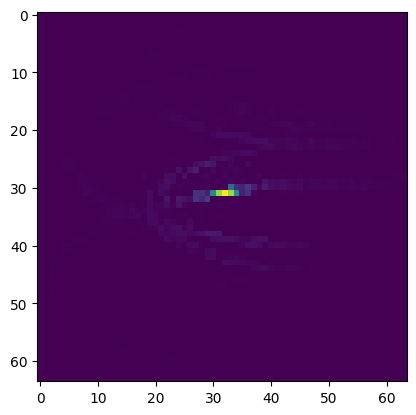

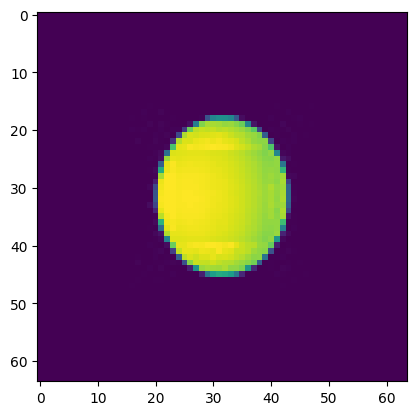

In [11]:
for element in [sample_input, sample_real]:
    plt.figure()
    plt.imshow(element)

### Preprocessing

In [12]:
training_size = 2800
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
BUFFER_SIZE = 2800 # number of training data images
img_size = 64
IMG_WIDTH = 64
IMG_HEIGHT = 64

In [13]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [14]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, img_size, img_size, 1])

  return cropped_image[0], cropped_image[1]

In [15]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [16]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 68, 68)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

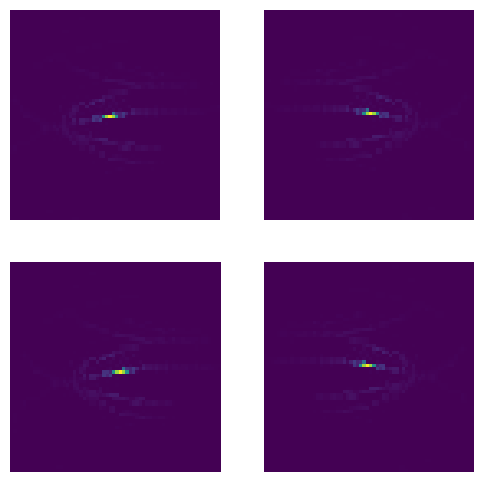

In [17]:
# Check if random_jitter works:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(sample_input, sample_real)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp)# / 255.0)
  plt.axis('off')
plt.show()

## Helper functions

In [18]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [19]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [20]:
train_dataset = tf.data.Dataset.list_files(str(PATH + '/train/*.jpg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [21]:
try:
  test_dataset = tf.data.Dataset.list_files(str(PATH + '/test/*.jpg'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(PATH + '/val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Generator

In [22]:
OUTPUT_CHANNELS = 1

In [23]:
# Encoder (downsample):
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, data_format="channels_last",
                             use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [24]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(tf.cast(sample_input, float), 0))
#down_result = down_model(tf.expand_dims(sample_image, 0))
print (down_result.shape)

(1, 32, 32, 3)


In [25]:
# Decoder (upsample):

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    data_format="channels_last",
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [26]:
up_model = upsample(3, 4, apply_dropout=True)
up_result = up_model(down_result)
print (up_result.shape)

(1, 64, 64, 3)


In [27]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[64, 64, 1])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    #downsample(512, 4),  # (batch_size, 2, 2, 512)
    #downsample(512, 4), # (batch_size, 1, 1, 512)
    # If 512 is too large, we can get stuck in local minima, or saddle points
    # Think about reducing it -> more efficient
    # If filters are reduced, we could try more layers
  ]

  up_stack = [
    #upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    #upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs


  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    #print(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    #print(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

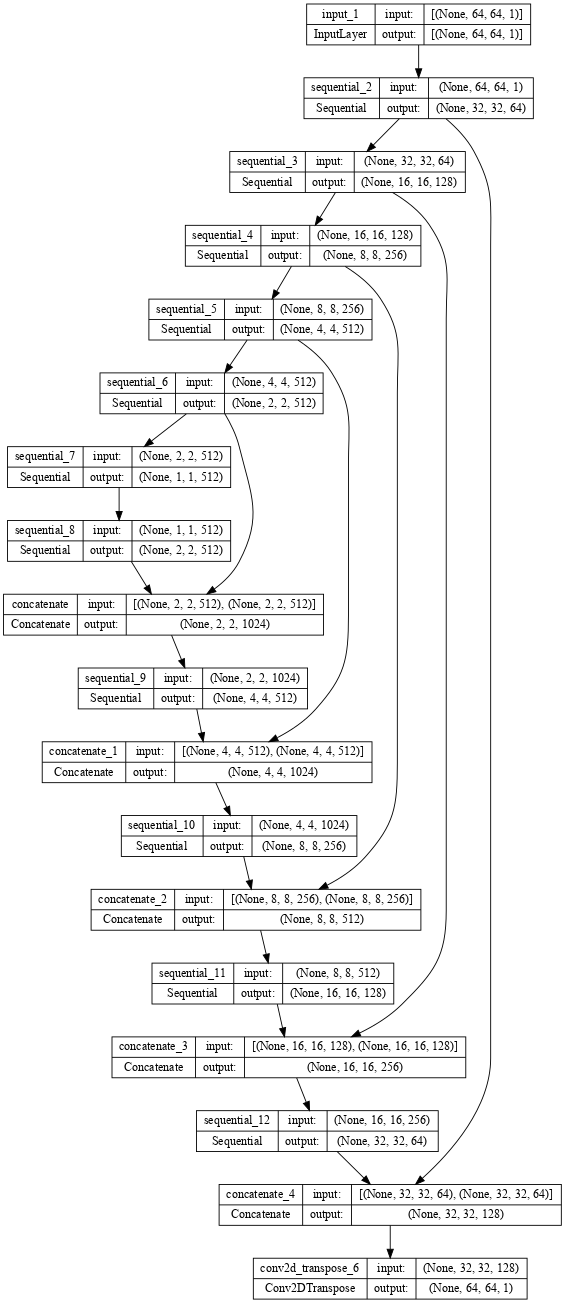

In [28]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

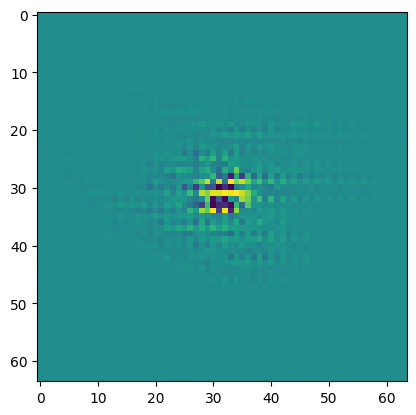

In [29]:
# Test generator
gen_output = generator(sample_input[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

### Generator loss

Calculate loss function (BinaryCrossentropy) of the generator; How well can it generate "fake" images, that look like the ground truth?

In [30]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def generator_loss(disc_generated_output, gen_output, target):
    # either 0 or 1
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output+0.0)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

## Discriminator 

In [31]:
# PROBLEM: IMAGES ARE MEANSHIFTED; WHAT TO DO ABOUT THIS?

In [32]:
# Define Salt-and-Pepper noise function
def Saltandpepper(image, prob, display_img=False):
    """
    Add salt and pepper noise to image
    prob: Probability of the noise
    """
    # If displaying images:
    if display_img:
        random_values = tf.random.uniform(shape=image.shape)
    else:
        random_values = tf.random.uniform(shape=image[0,:,:,:].shape)

    image = tf.where(random_values < (prob/2), 127., image)
    image = tf.where(1 - random_values < (prob/2), 0., image)
    
    return image


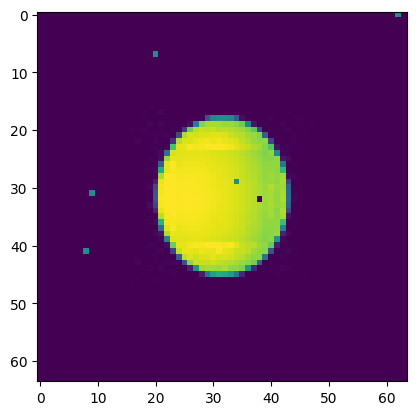

In [33]:
plt.imshow(Saltandpepper(sample_real, 0.005, display_img=True))

In [34]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp_ = tf.keras.layers.Input(shape=[64, 64, 1], name='input_image')
  tar = tf.keras.layers.Input(shape=[64, 64, 1], name='target_image') # generated by the generator

  # Add Salt-and-Pepper noise to the input
  inp = Saltandpepper(inp_, beta)


  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(32, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(64, 4)(down1)  # (batch_size, 64, 64, 128)
  #down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down2)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(256, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

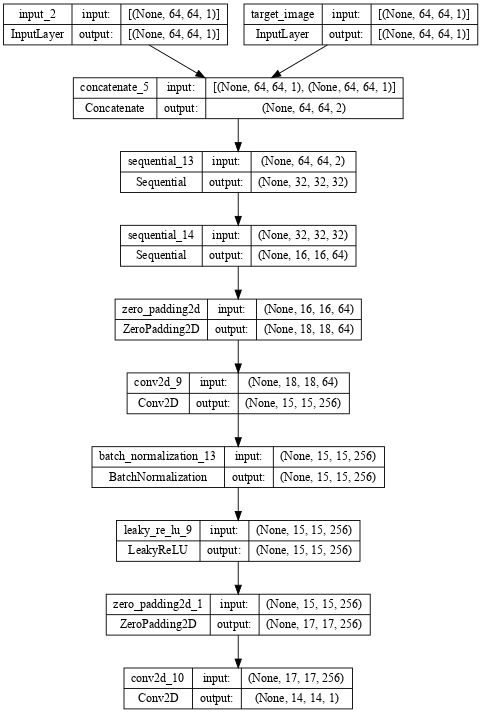

In [35]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

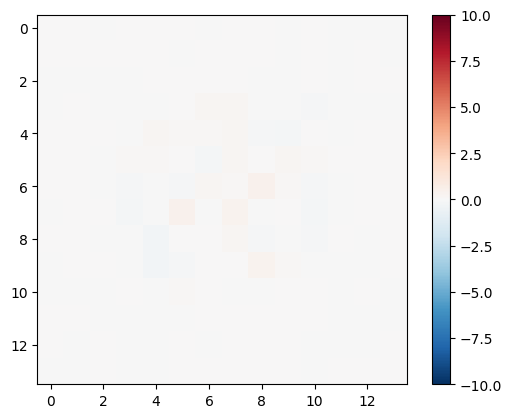

In [36]:
# Test discriminator
disc_out = discriminator([sample_input[tf.newaxis, :], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-10, vmax=10, cmap='RdBu_r')
plt.colorbar()

### Disciminator loss

In [37]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

## Optimizer

In [38]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [39]:
checkpoint_dir = './training_checkpoints/v0.6'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate Images

In [40]:
# Plot images during training. Use training=True to show the batch statistics, not the accumulated statistics. 
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]*0.5 + 0.5]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i]* 0.5 + 0.5)
    plt.axis('off')
  plt.show()

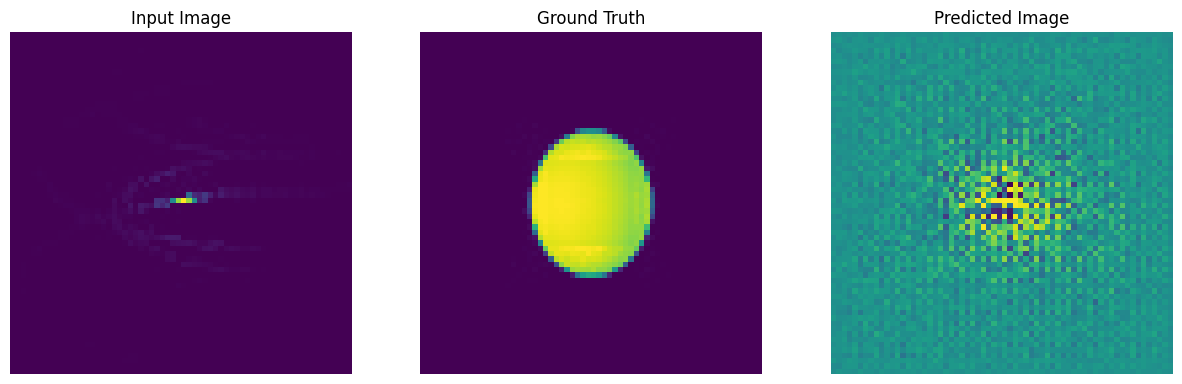

In [41]:
example_input = sample_input[tf.newaxis, :]
example_target = sample_real[tf.newaxis, :]

generate_images(generator, example_input, example_target)

## Training

In [ ]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

Idea: Freeze generator for a few steps and train discriminator more (e.g. factor 5)

Implementation: Separate gen_tape and disc_tape

In [ ]:
disc_train_iterations = 1

In [ ]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape:
        gen_output = generator(input_image, training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        
    generator_gradients = gen_tape.gradient(gen_total_loss,
                                              generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients,
                                              generator.trainable_variables))


    # Loop over discriminator separately -> increases relative training of discriminator
    for i in range(disc_train_iterations):
        with tf.GradientTape() as disc_tape:
            gen_output = generator(input_image, training=True)
            disc_real_output = discriminator([input_image, target], training=True)
            disc_generated_output = discriminator([input_image, gen_output], training=True)
            disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
        
        # Check if this works as expected: 
        # print(generator_optimizer)


    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [ ]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

%load_ext tensorboard
%tensorboard --logdir {log_dir}

Time taken for 1000 steps: 110.76 sec



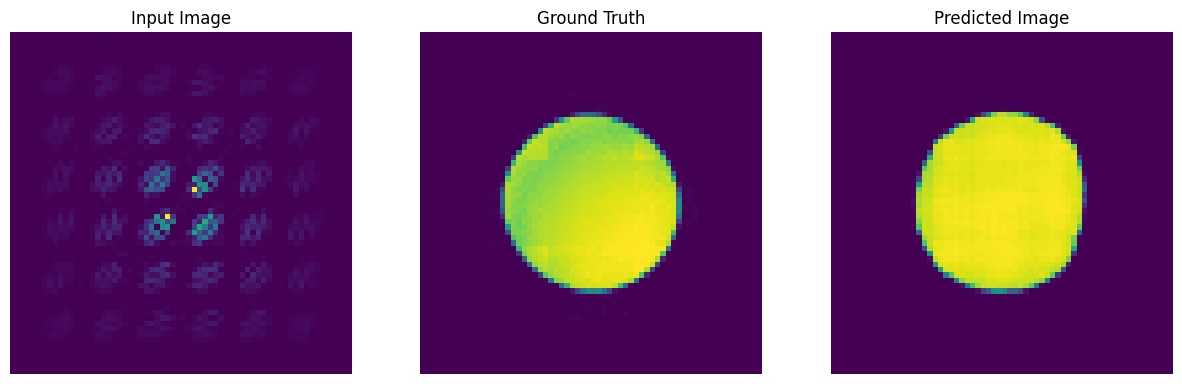

Step: 32k
..........................................................................

In [ ]:
fit(train_dataset, test_dataset, steps=60000)

## Restore old checkpoints

In [42]:
checkpoint_dir = "models/models/ellipsoids_run7.2_a0.005_b0.005_discrep1_it60k_teles4_base/"

In [43]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [44]:
print(tf.train.latest_checkpoint(checkpoint_dir))

models/models/ellipsoids_run7.2_a0.005_b0.005_discrep1_it60k_teles4_base/ckpt-12


## Generate images with test set

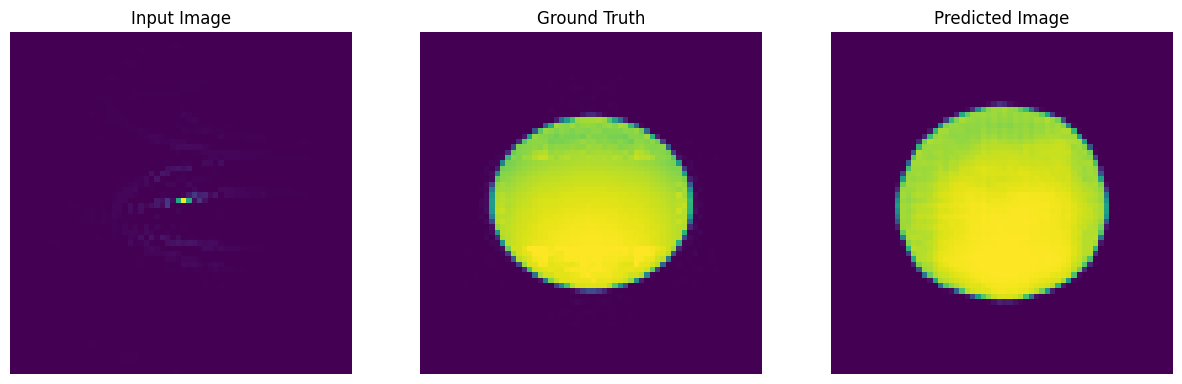

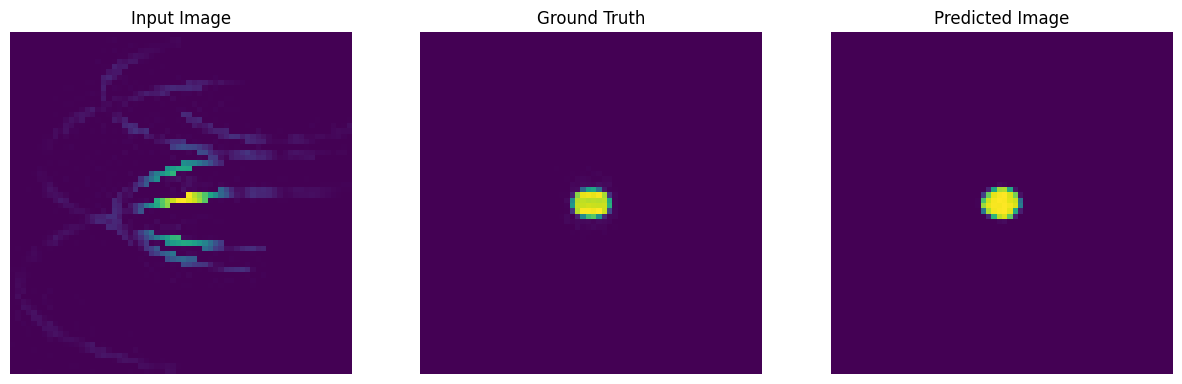

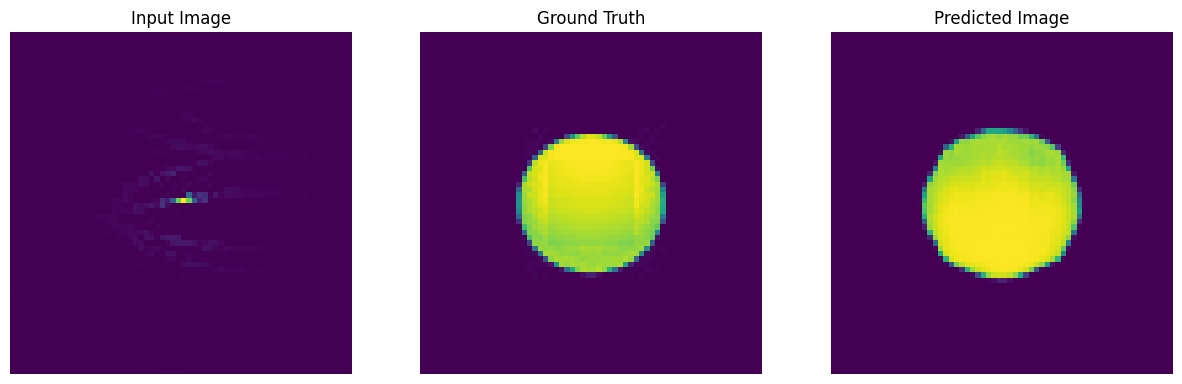

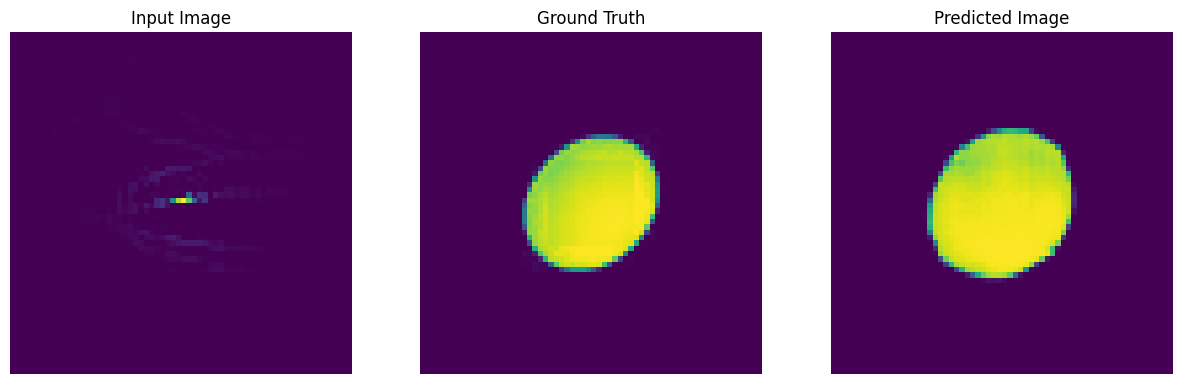

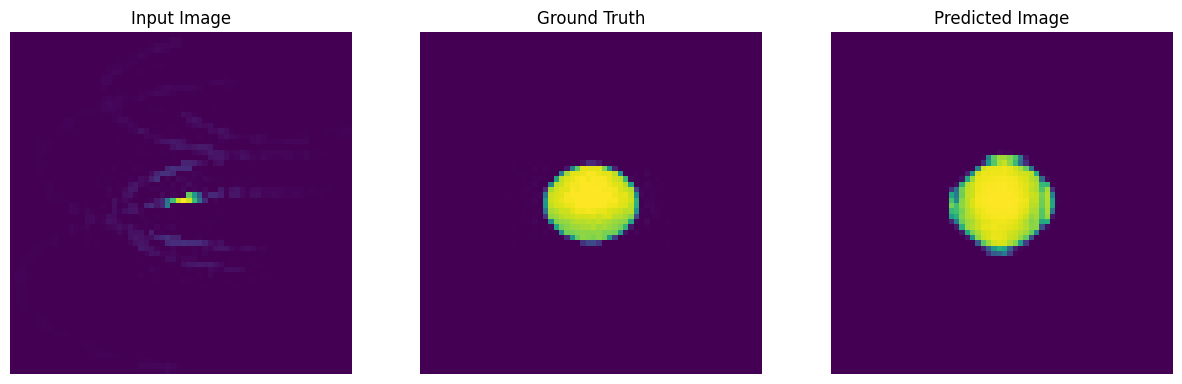

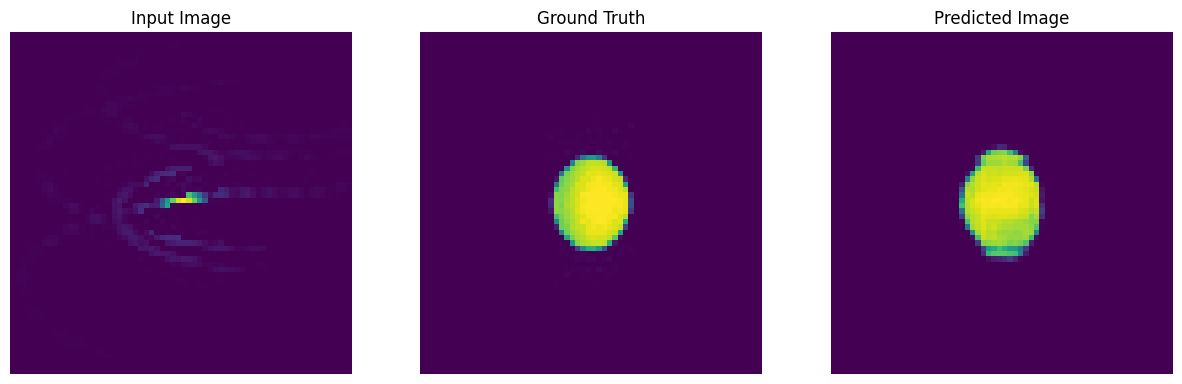

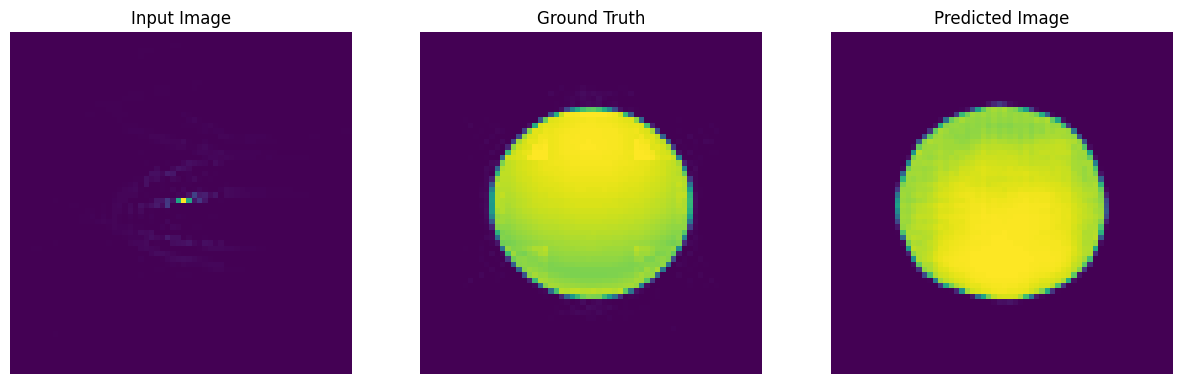

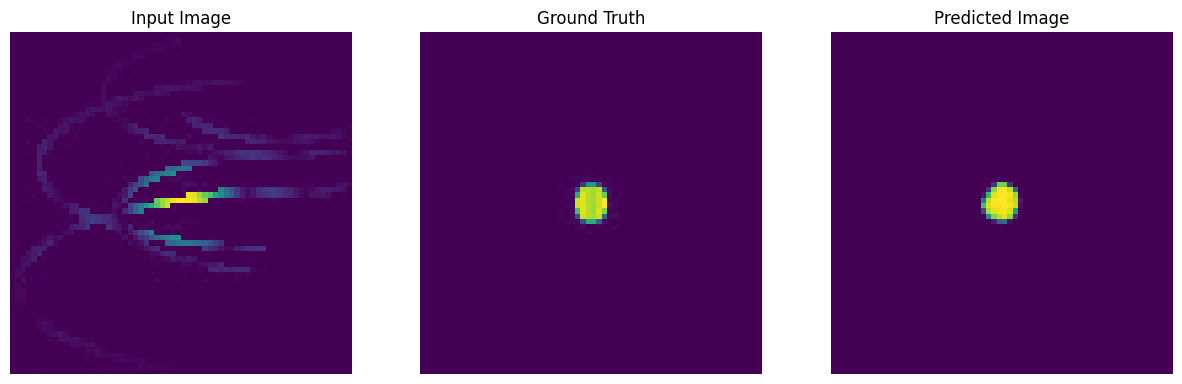

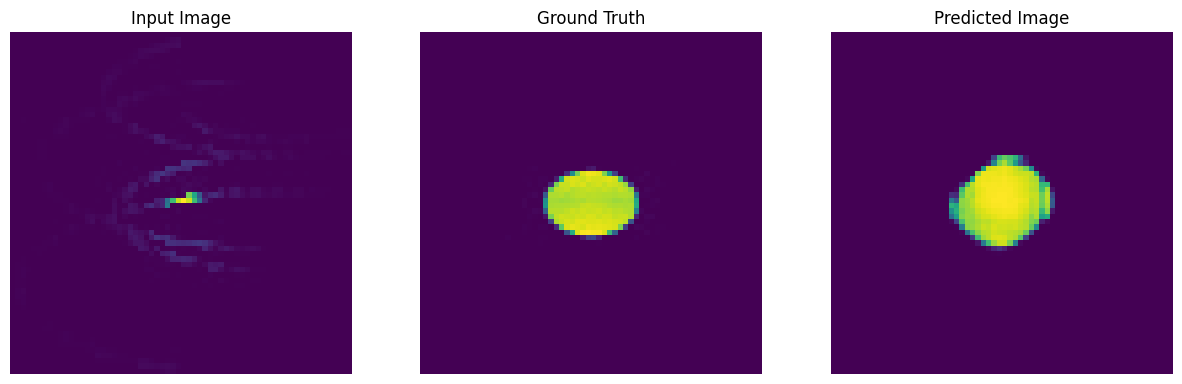

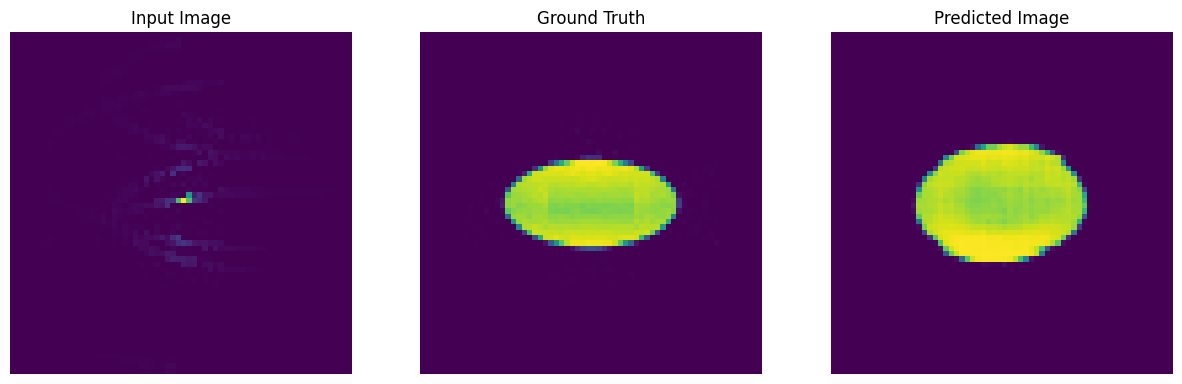

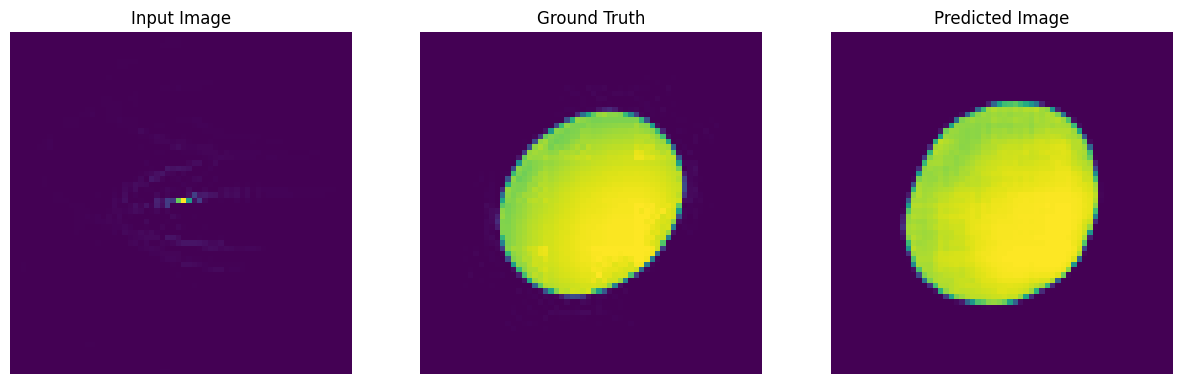

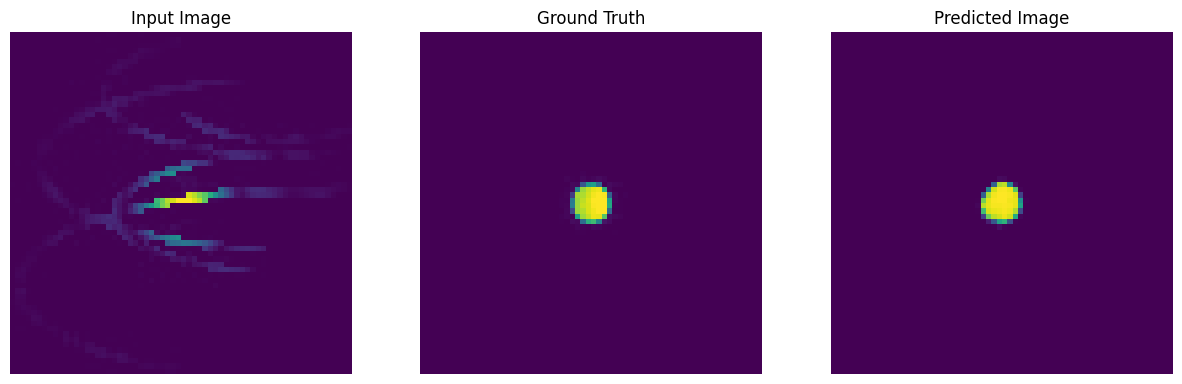

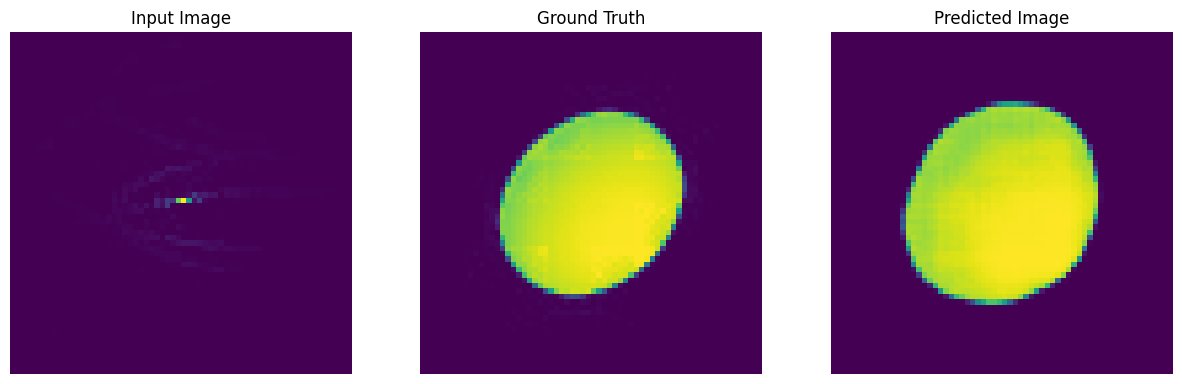

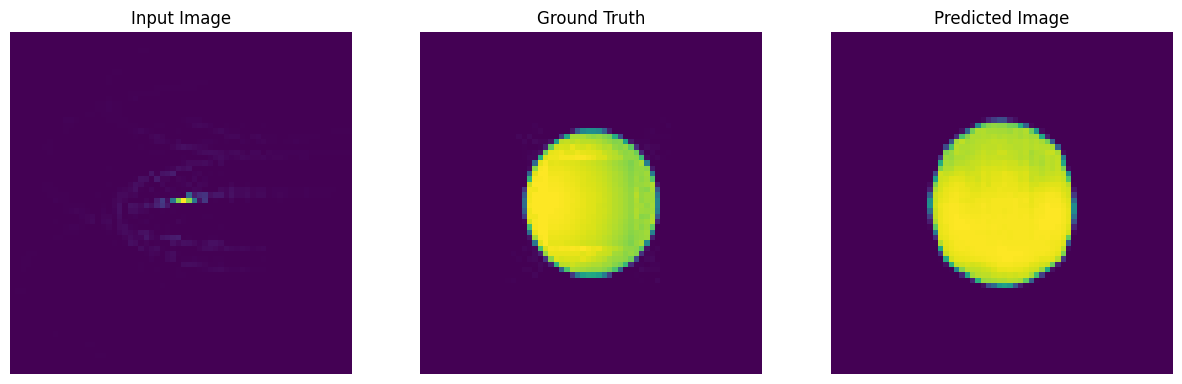

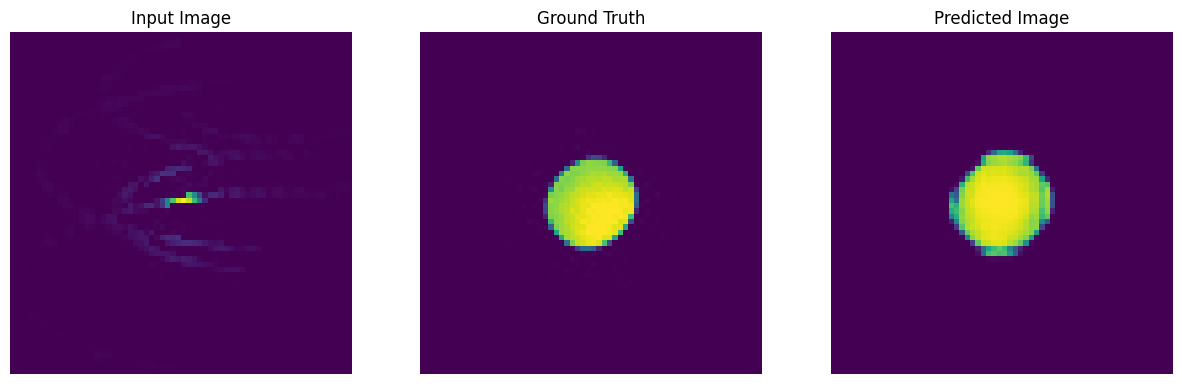

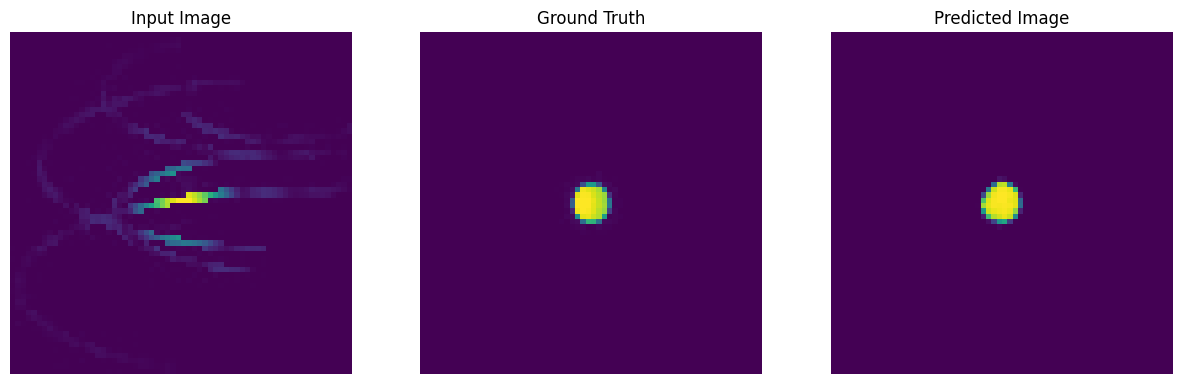

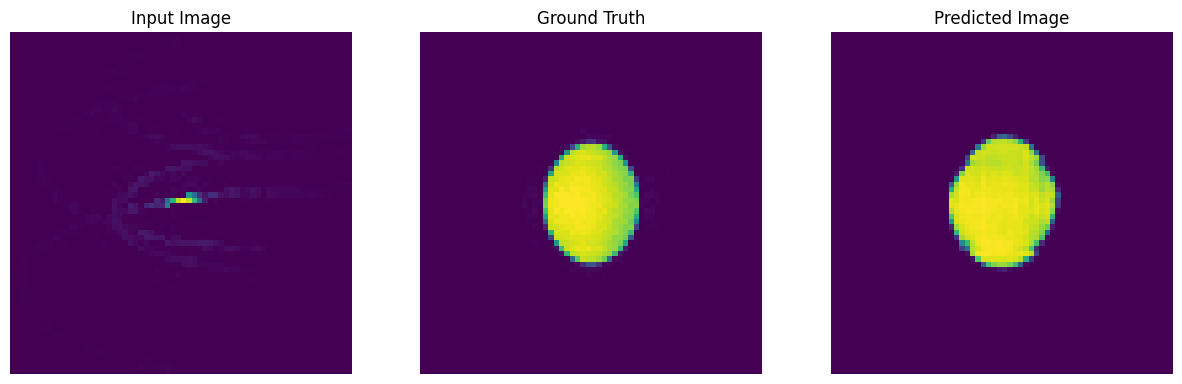

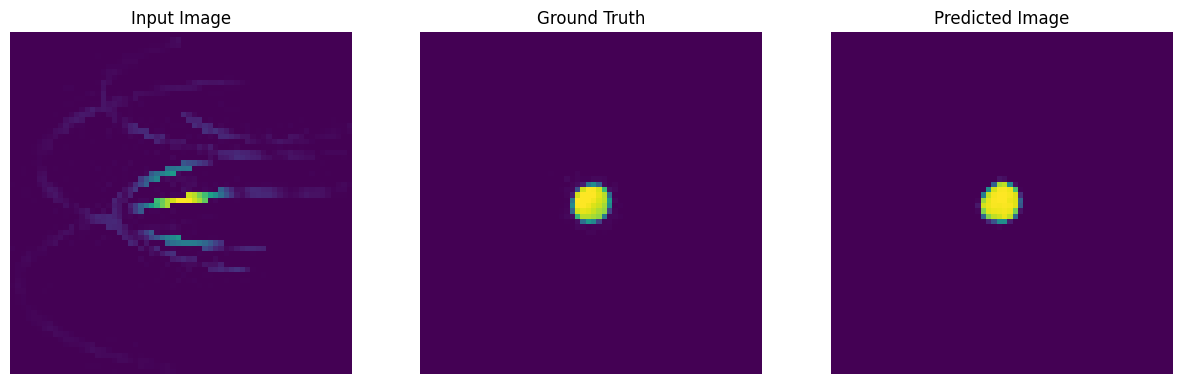

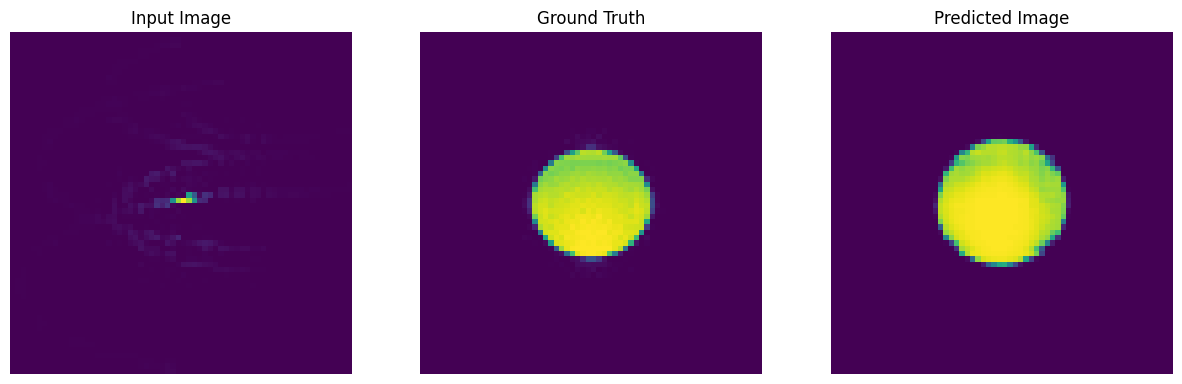

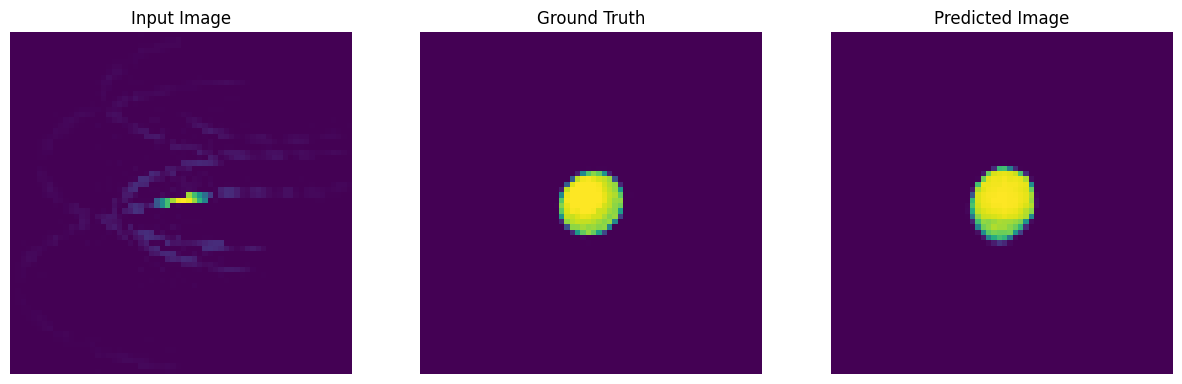

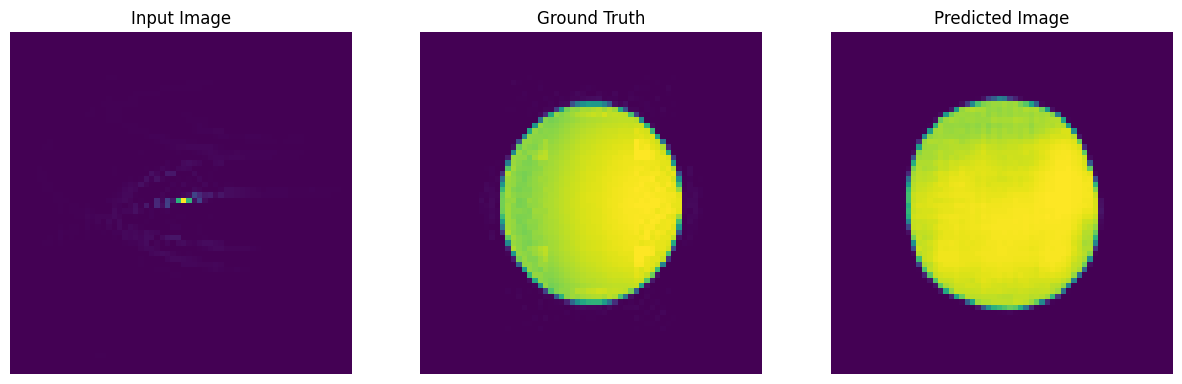

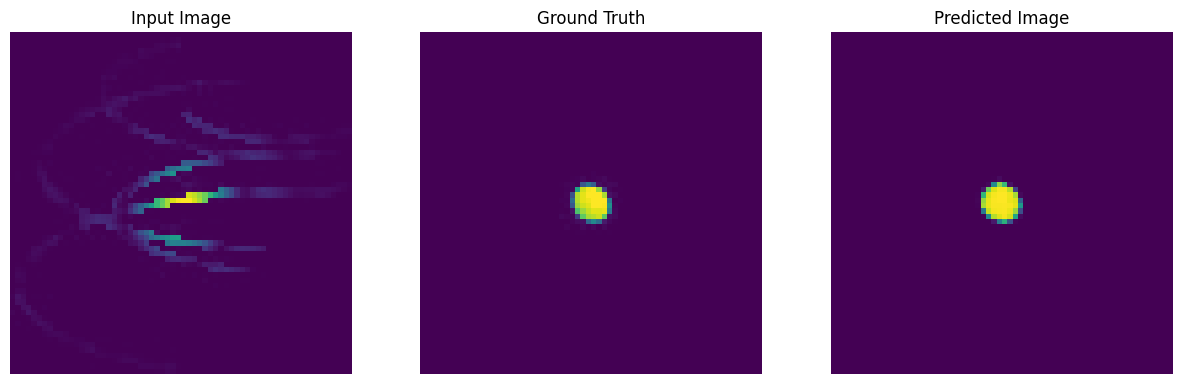

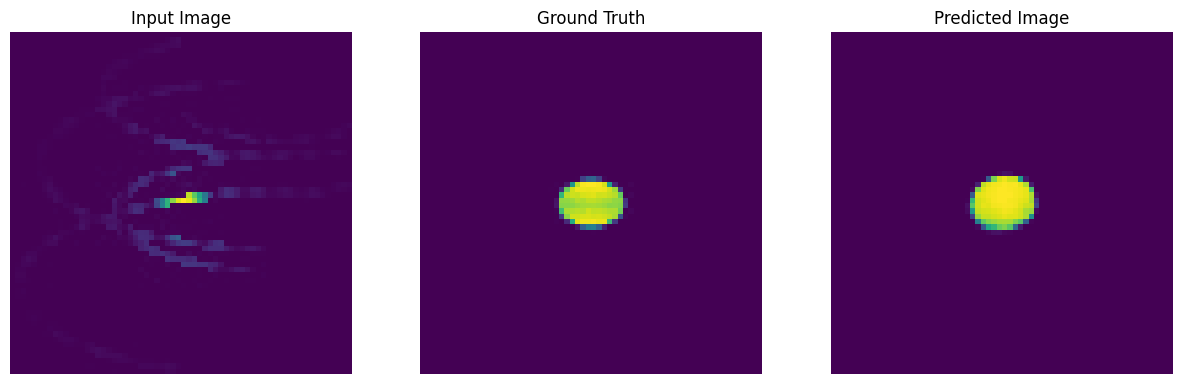

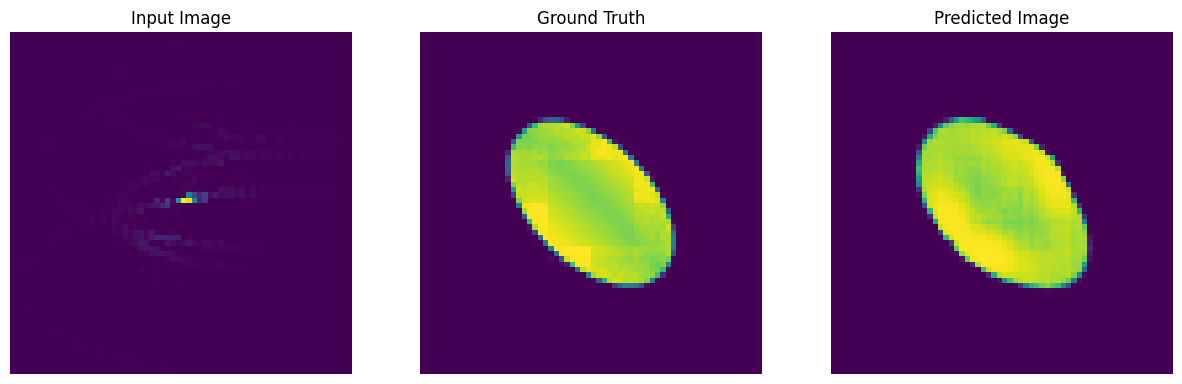

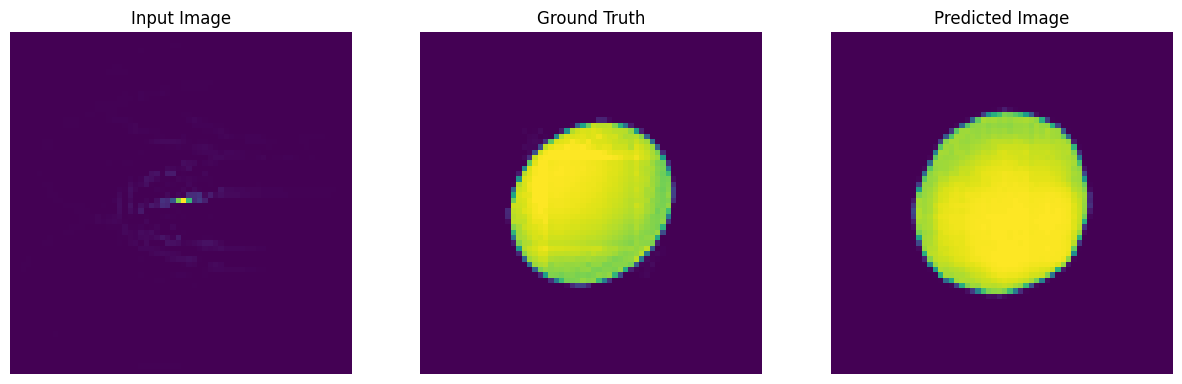

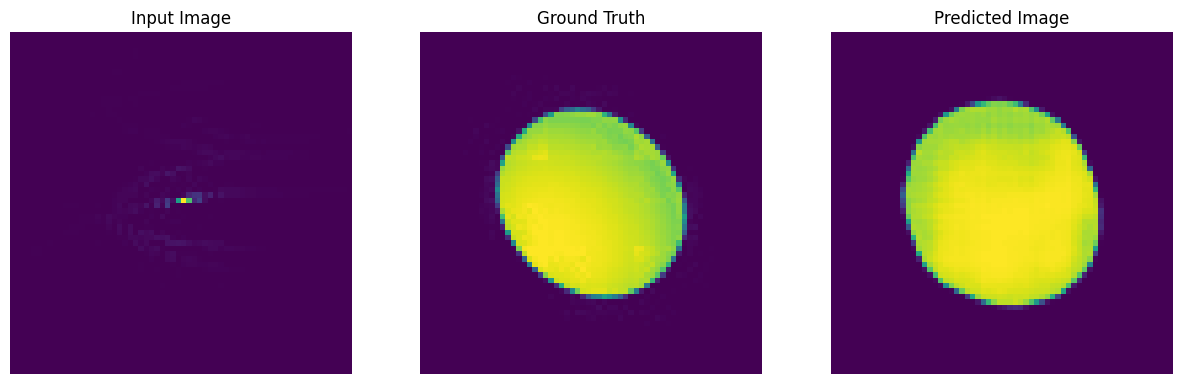

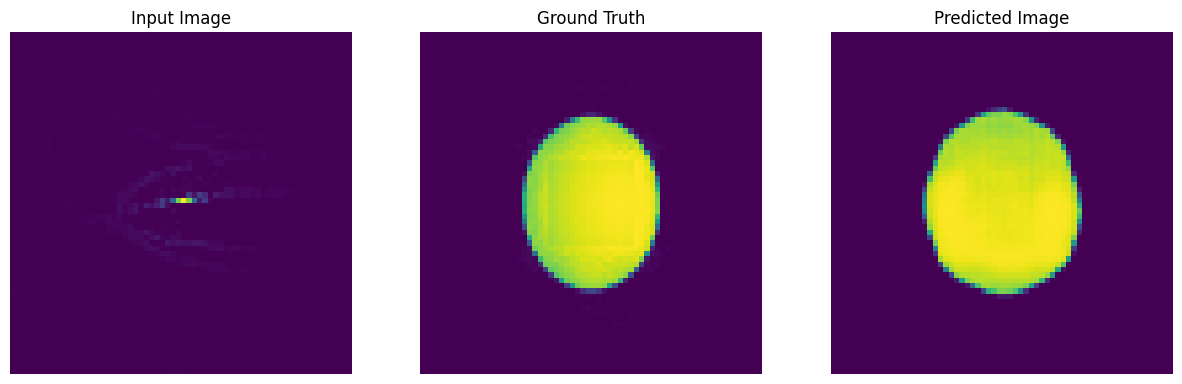

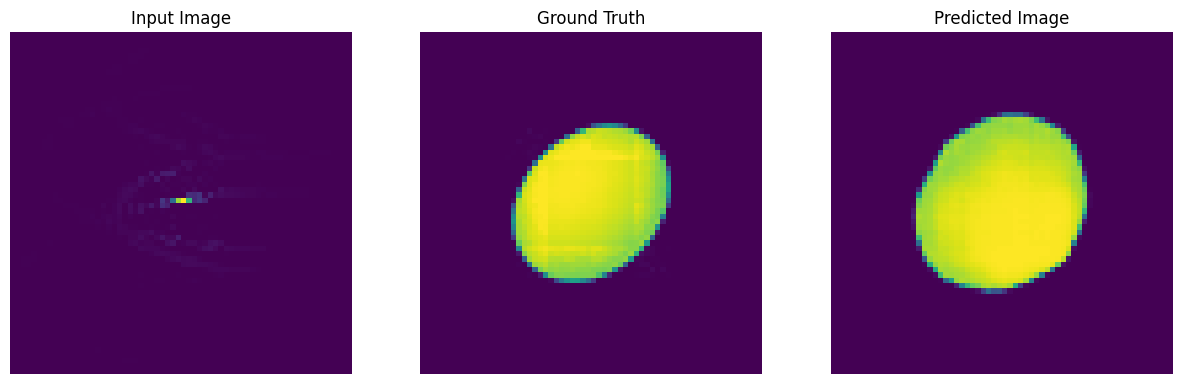

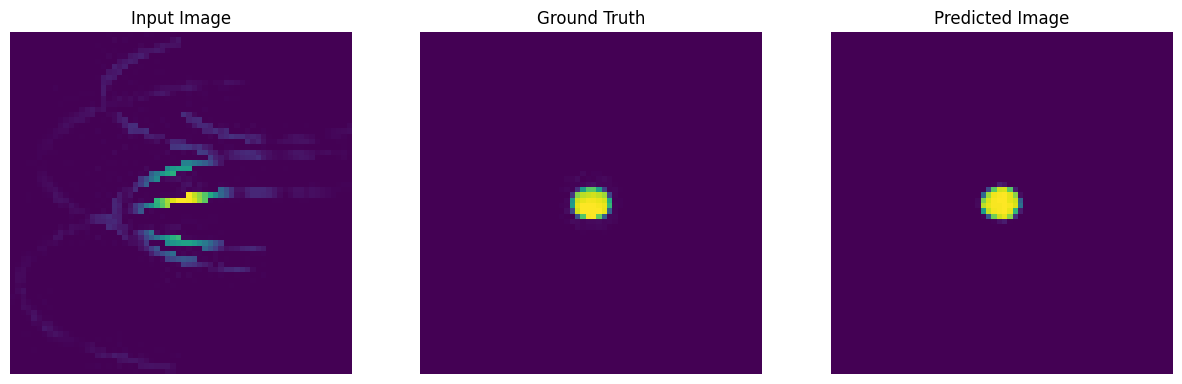

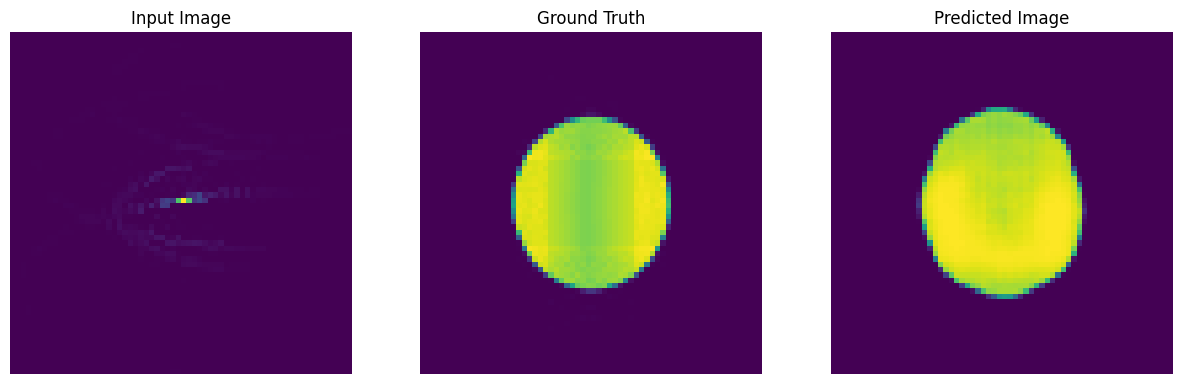

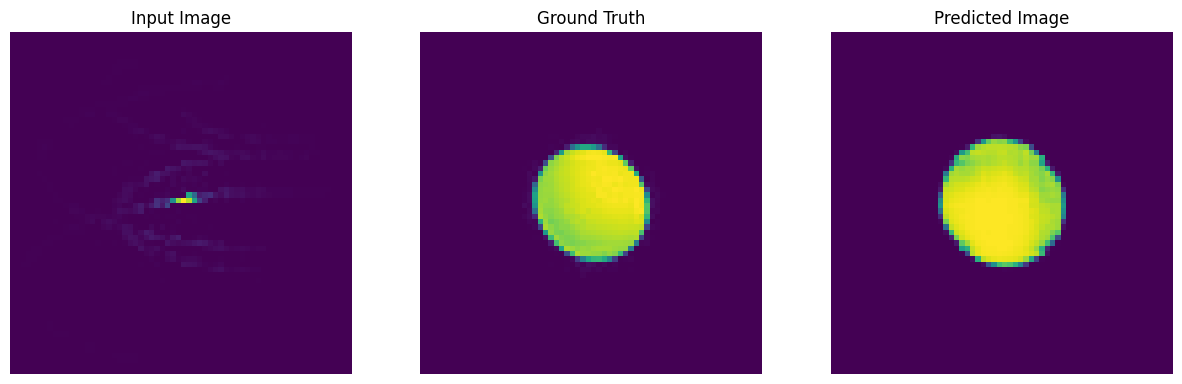

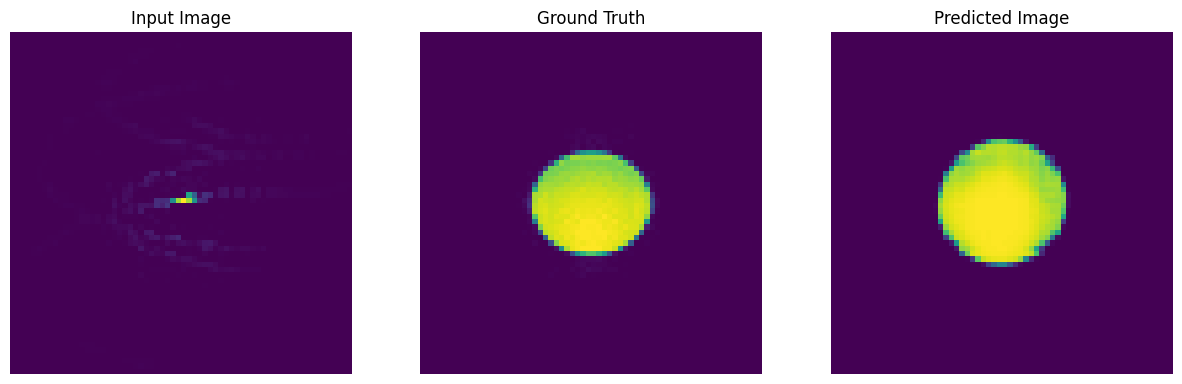

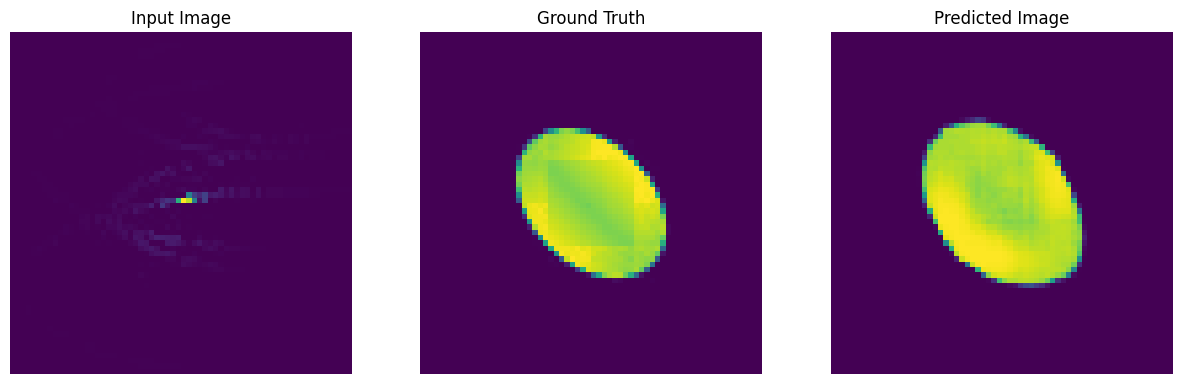

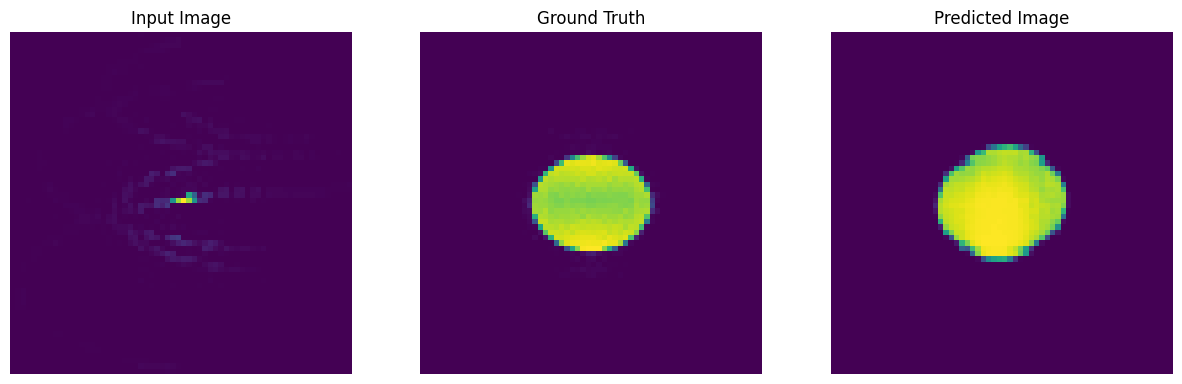

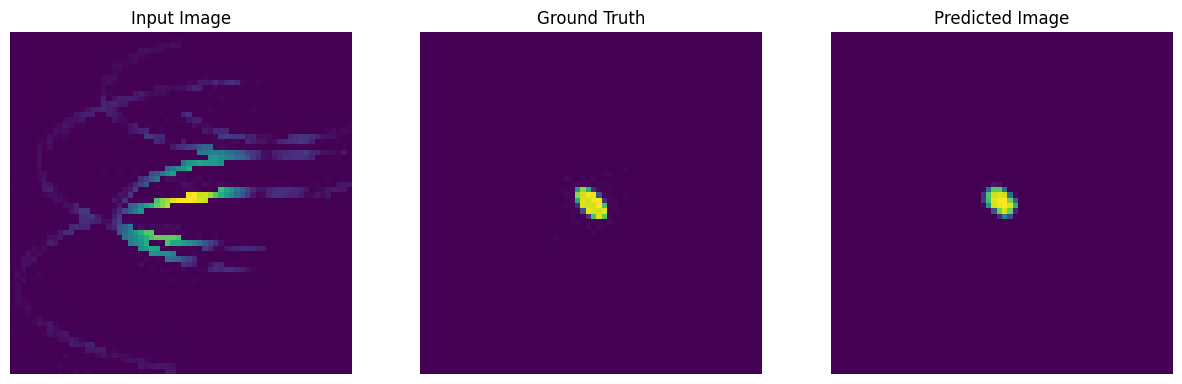

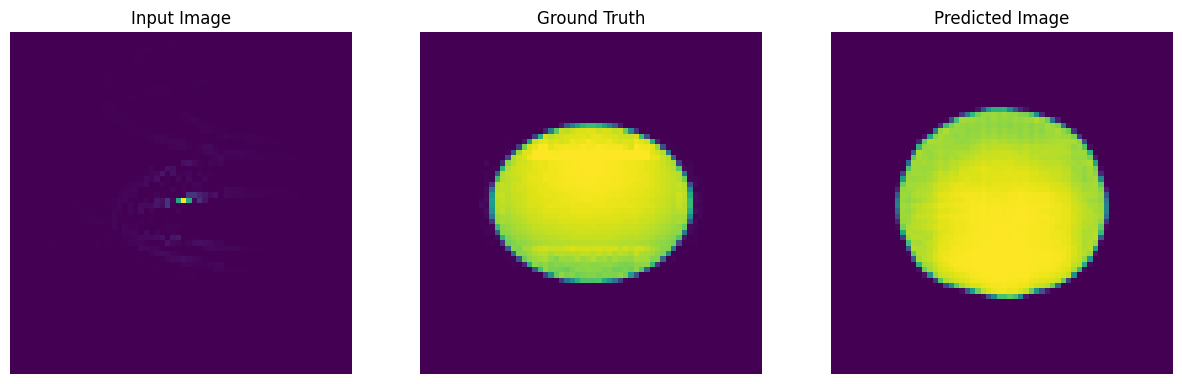

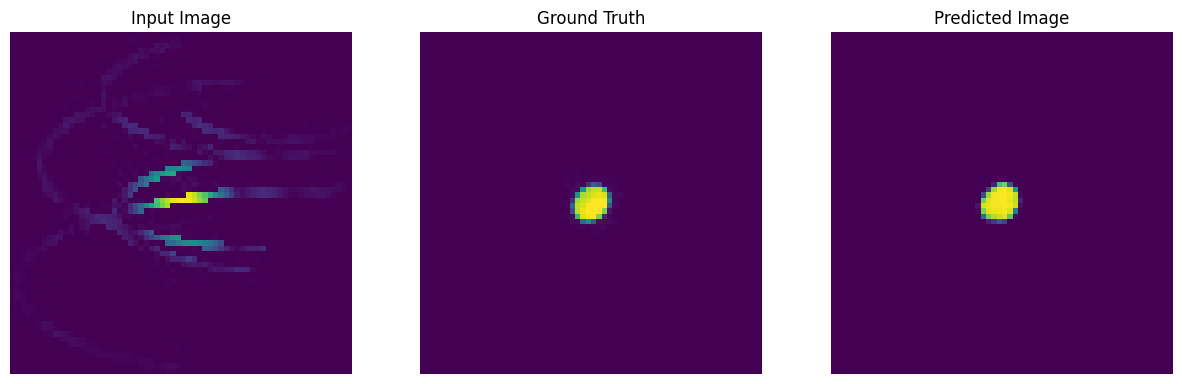

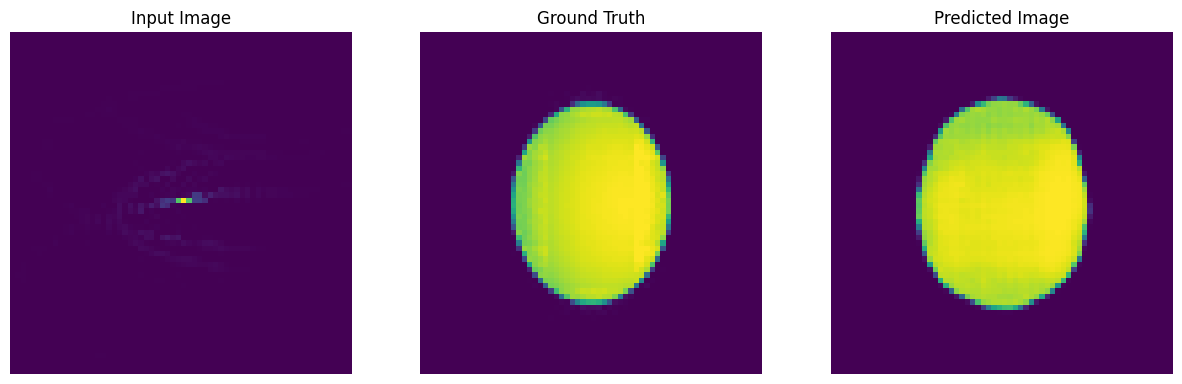

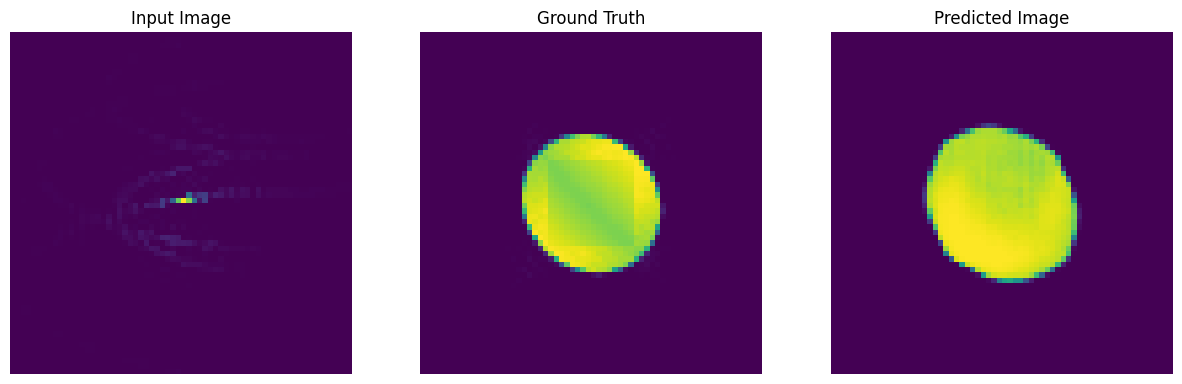

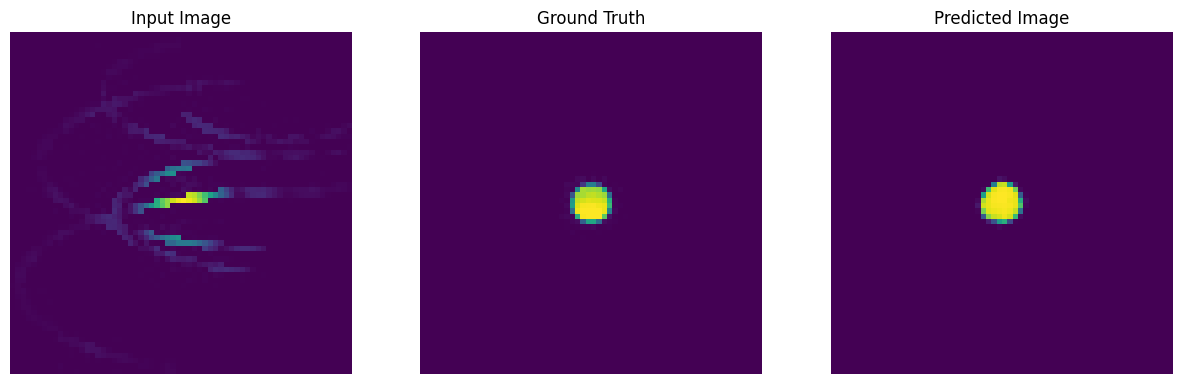

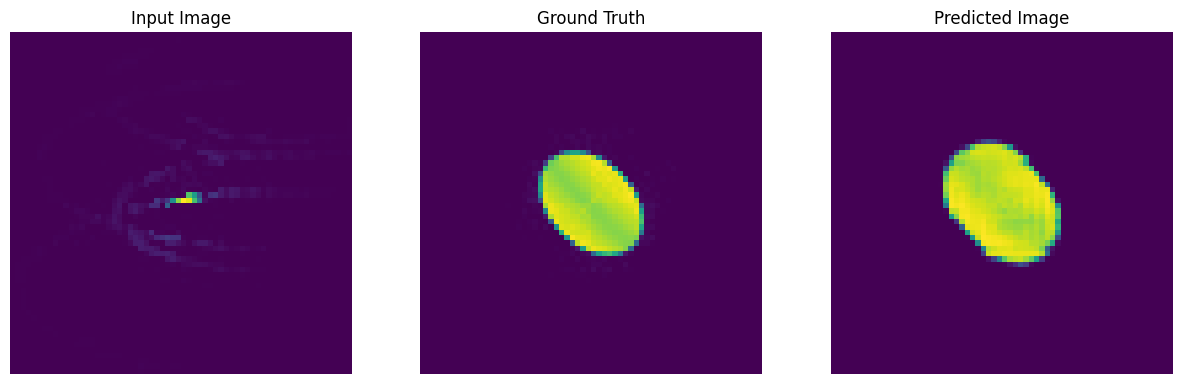

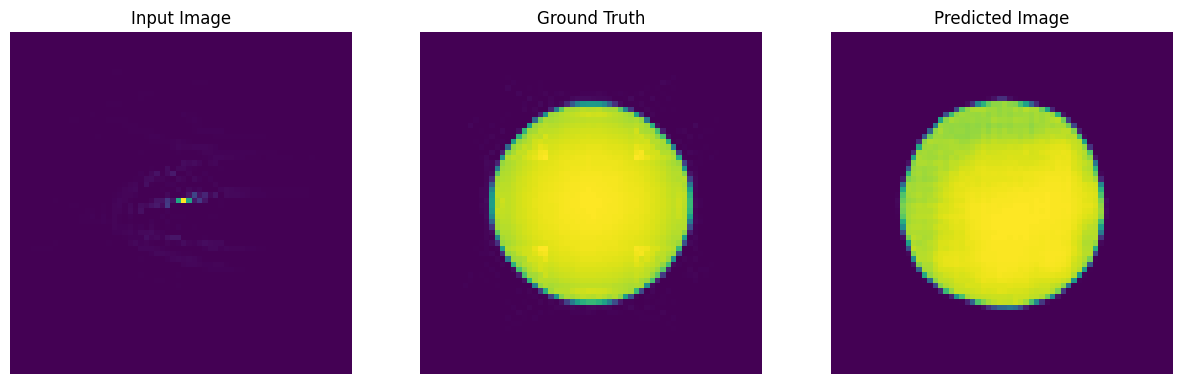

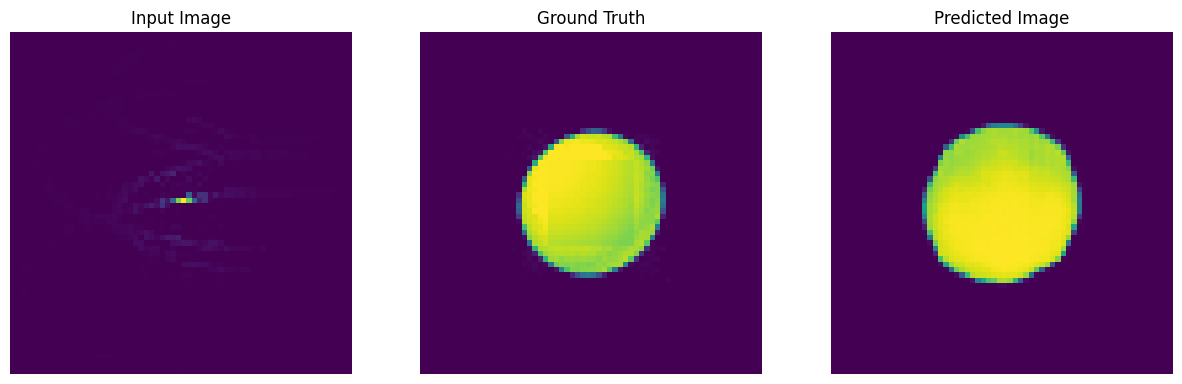

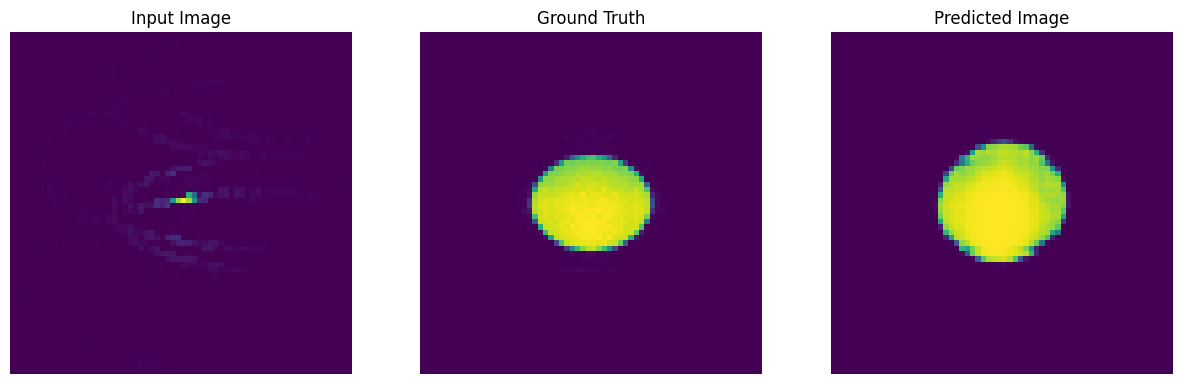

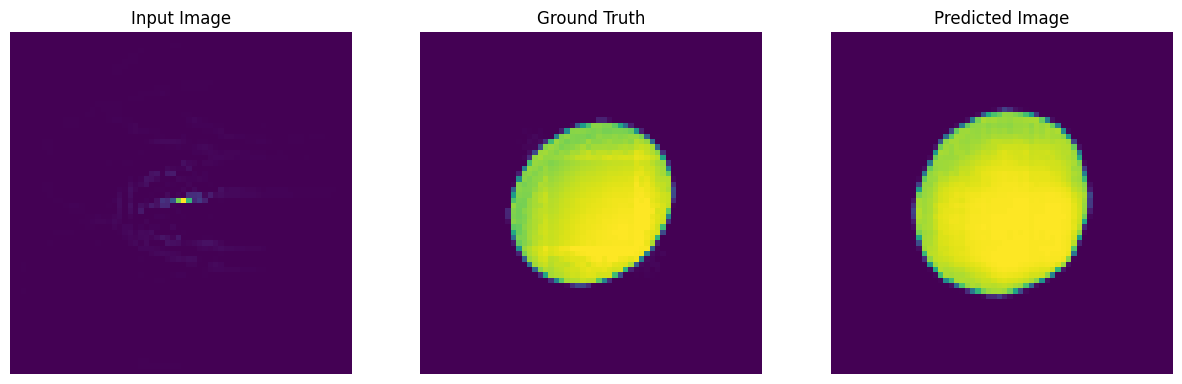

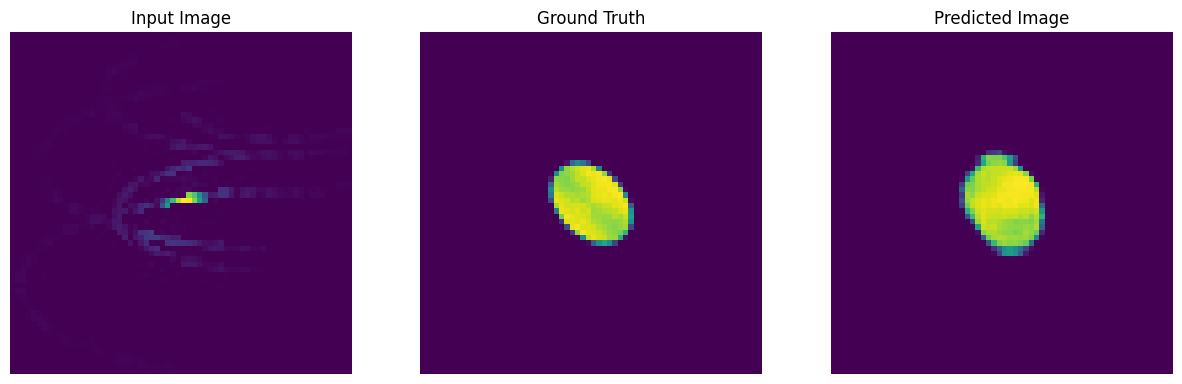

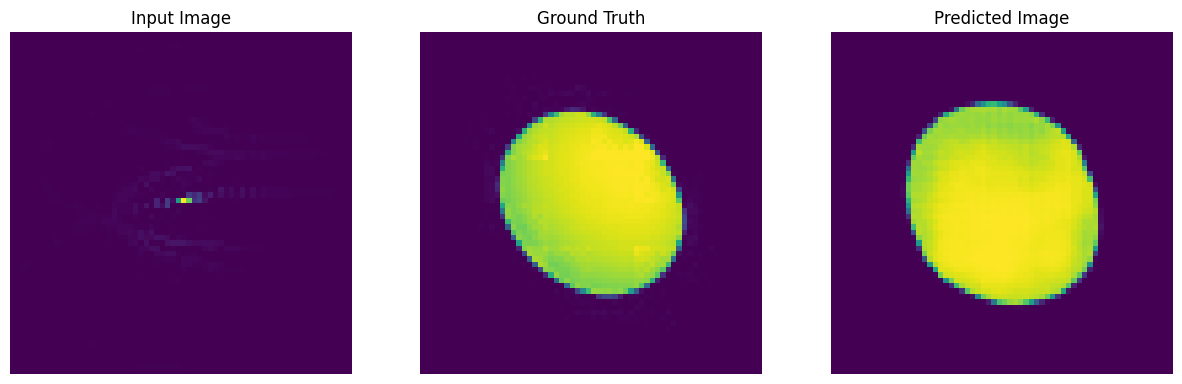

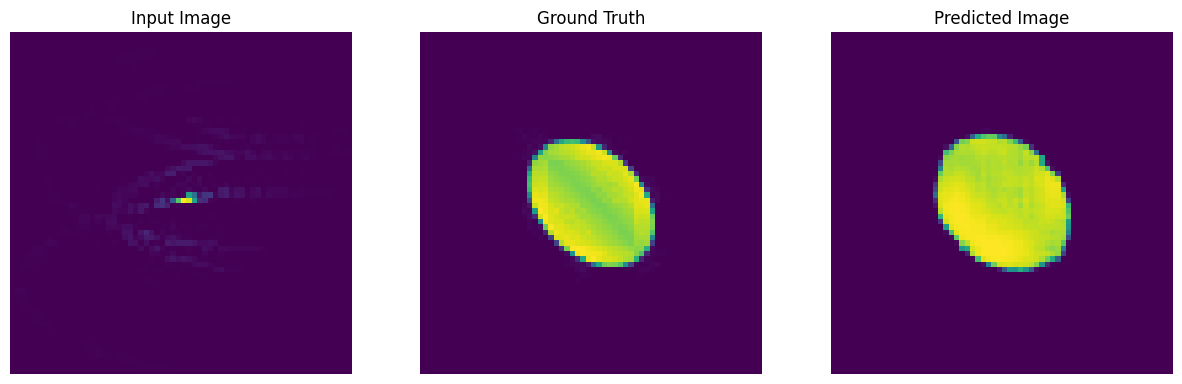

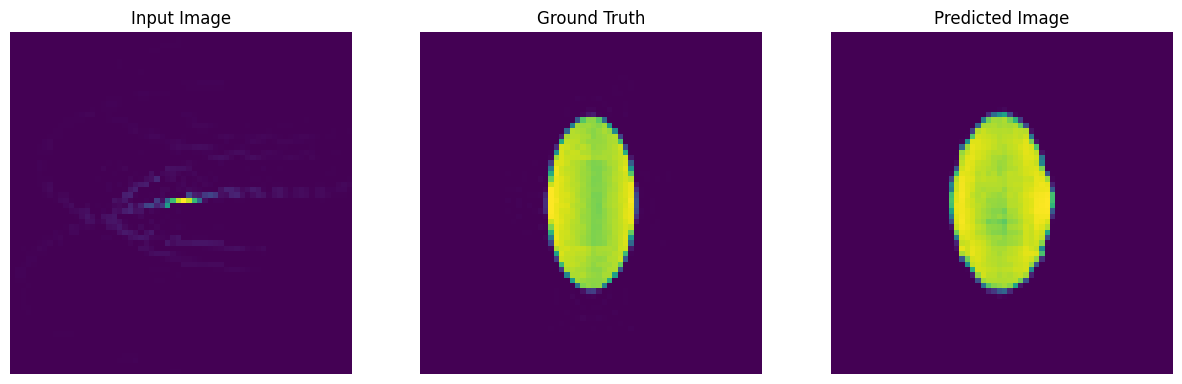

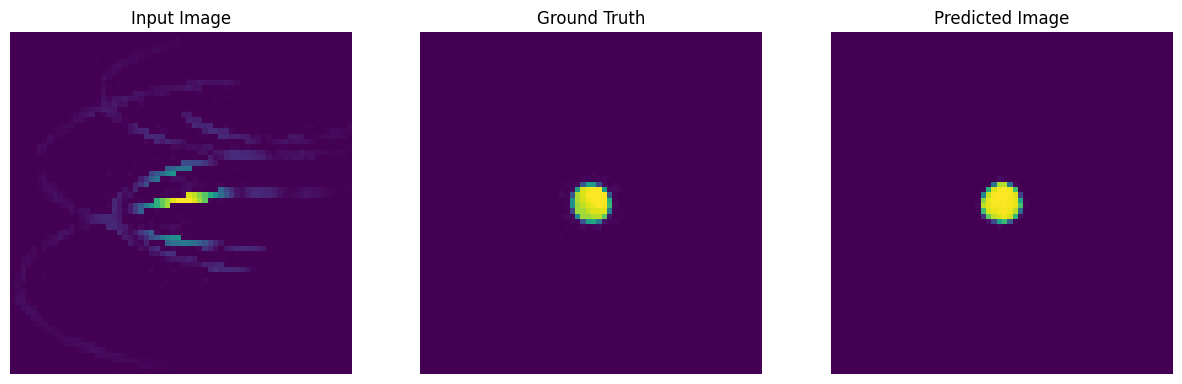

In [45]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(50):
  generate_images(generator, inp, tar)